In [102]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [103]:
import os
import numpy as np
import pandas as pd
from datetime import datetime
import argparse
import time
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib as mpl

import sys
sys.path.append('../..')
from data.dataloader import get_covid19india_api_data
from main.seir.fitting import single_fitting_cycle, get_variable_param_ranges
from main.seir.fitting import get_all_district_data, data_setup, run_cycle
from main.seir.forecast import create_all_csvs, write_csv, plot_forecast

In [104]:
def backtesting(df_district, df_district_raw_data, increment=5, future_days=10, optimize_runs=3, max_evals=100, train_period=7, val_period=7):
    runtime_s = time.time()
    start = pd.to_datetime(df_district['date']).min()
    end = pd.to_datetime(df_district['date']).max()
    print(start, end)
    n_days = (end - start).days + 1 - future_days
    # model = model.generate()
    results = {}
    seed = datetime.today().timestamp()
    for run_day in range(train_period + val_period + 1, n_days, increment):
        end_date = pd.to_datetime(df_district['date'], format='%Y-%m-%d').loc[run_day]
        print ("\rbacktesting for", end_date, end="")

        #  TRUNCATE DATA
        df_district_incr = df_district[pd.to_datetime(df_district['date'], format='%Y-%m-%d') <= end_date]
        df_district_raw_data_incr = df_district_raw_data[pd.to_datetime(df_district_raw_data['date'], format='%Y-%m-%d') <= end_date]
        
        df_district_incr, df_district_raw_data_incr, df_train, df_val, df_true_fitting, df_train_nora, df_val_nora = \
            data_setup(df_district_incr, df_district_raw_data_incr, pre_lockdown, train_on_val, val_period)
        
        # FIT/PREDICT
        res = run_cycle(
            state, district, df_district_incr, df_district_raw_data_incr, df_train, df_val, df_train_nora, df_val_nora, data_from_tracker,
            train_period=train_period, train_on_val=train_on_val, num_evals=num_evals, N=N, 
            which_compartments=which_compartments, initialisation=initialisation
        )

        results[end_date] = {
            'n_days': n_days,
            'seed': seed,
            'results': res,
        }
    runtime = time.time() - runtime_s
    print (runtime)
    out = {
        'results': results,
        'df_district': df_district,
        'future_days': future_days,
        'runtime': runtime,
    }
    return out

In [105]:
dataframes = get_covid19india_api_data()


In [106]:
state, district = 'Maharashtra', 'Pune'
fit = 'm1' # 'm1' or 'm2'
data_from_tracker=False

In [107]:
train_period = 7
N = 1e7
pre_lockdown = False
initialisation = 'intermediate'
which_compartments = ['hospitalised', 'total_infected', 'deceased', 'recovered']

val_period = 7 if fit is 'm1' else 0
train_on_val = False if fit is 'm1' else True
num_evals = 700 if data_from_tracker else 1000

if district == 'Mumbai':
    data_format = 'old'
    filepath = '../../data/data/official-mumbai.csv'
elif district == 'Pune':
    data_format = 'new'
    filepath = '../../data/data/official-pune-21-05-20.csv'

In [108]:
df_district, df_district_raw_data = get_all_district_data(dataframes, state, district, 
                data_from_tracker, data_format, filepath)

2020-04-19 00:00:00 2020-05-18 00:00:00
backtesting for 2020-05-04 00:00:00splitting data ..
splitting data ..
100%|██████████| 1000/1000 [02:05<00:00,  7.97trial/s, best loss: 5.325390563031281]
best parameters
 {'E_hosp_ratio': 0.7893019975797683, 'I_hosp_ratio': 0.42925705778808515, 'P_fatal': 0.1570902477022988, 'P_severe': 0.8377367019765181, 'T_inc': 4.526963344204587, 'T_inf': 3.3507020612611997, 'T_recov_severe': 37.68600311975668, 'lockdown_R0': 1.2311852186557954}
backtesting for 2020-05-05 00:00:00splitting data ..
splitting data ..
100%|██████████| 1000/1000 [02:06<00:00,  7.91trial/s, best loss: 4.427060898940539]
best parameters
 {'E_hosp_ratio': 0.6768268211843067, 'I_hosp_ratio': 0.48856922674802555, 'P_fatal': 0.14986914681650937, 'P_severe': 0.8025543842323378, 'T_inc': 4.110444156872495, 'T_inf': 3.827599509385951, 'T_recov_severe': 46.41979090313064, 'lockdown_R0': 1.2981232451463038}
backtesting for 2020-05-06 00:00:00splitting data ..
splitting data ..
100%|██████

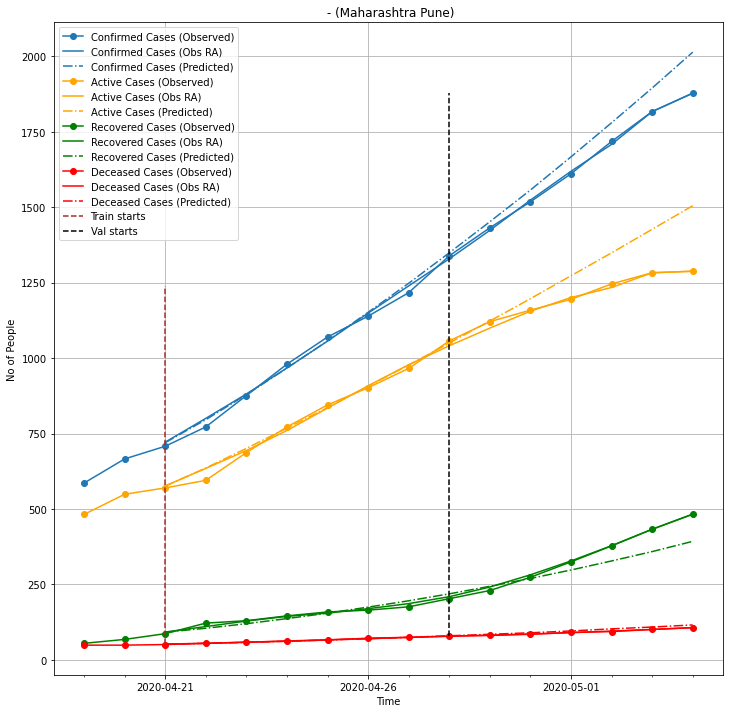

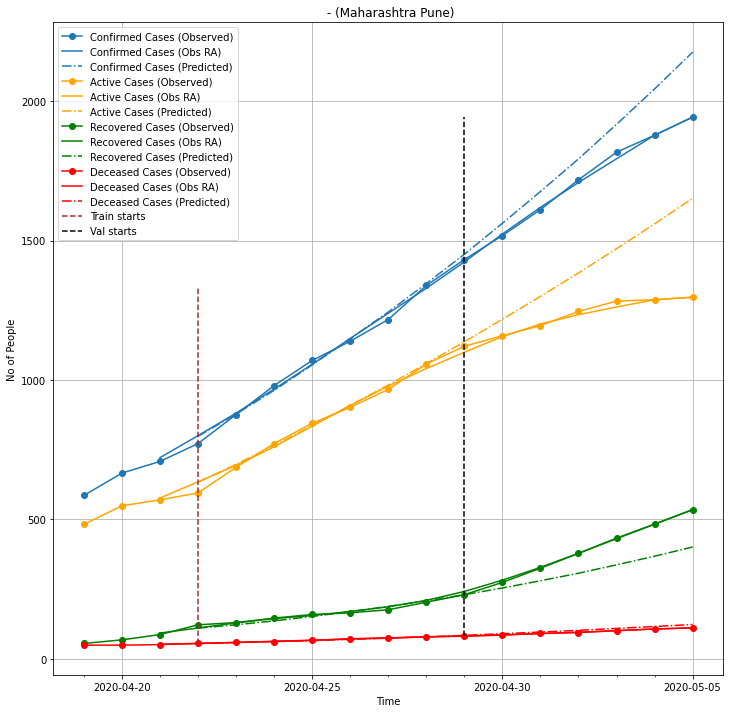

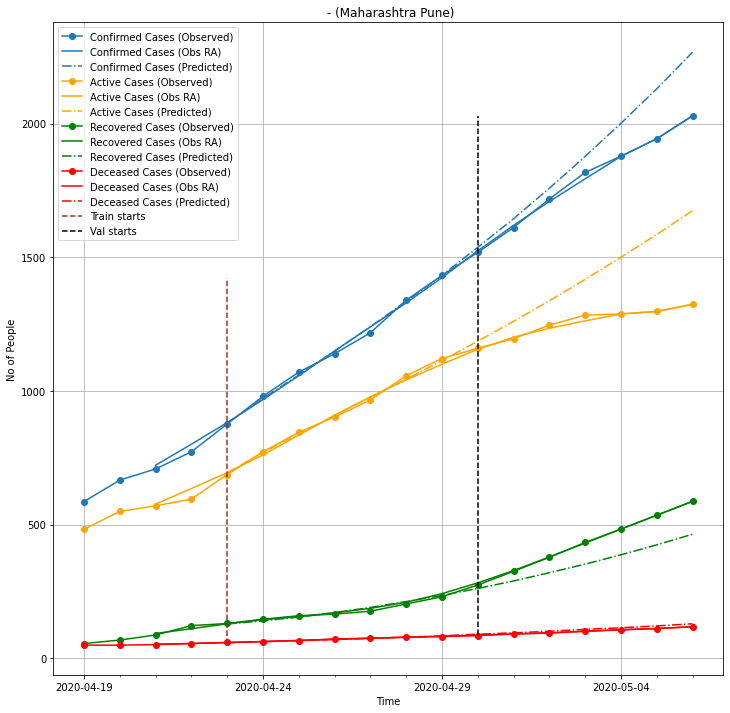

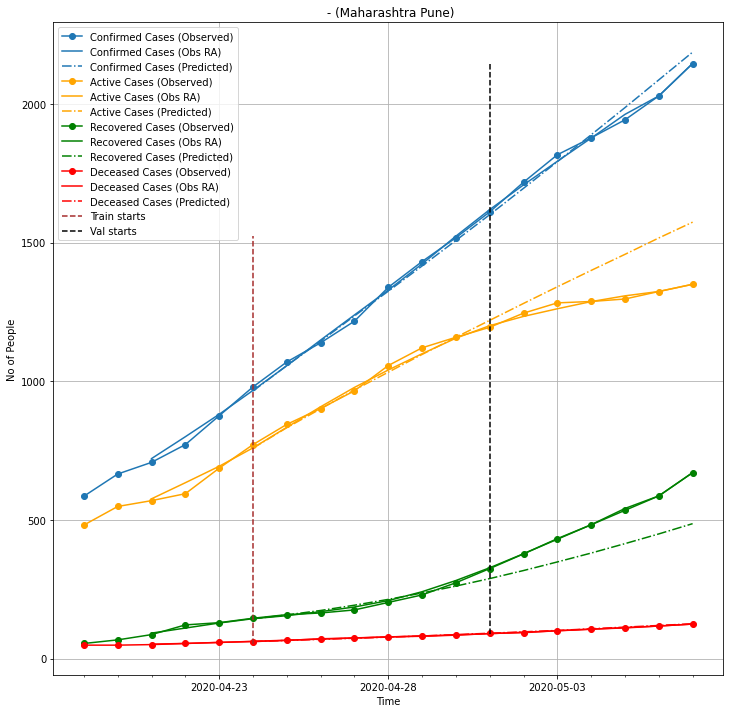

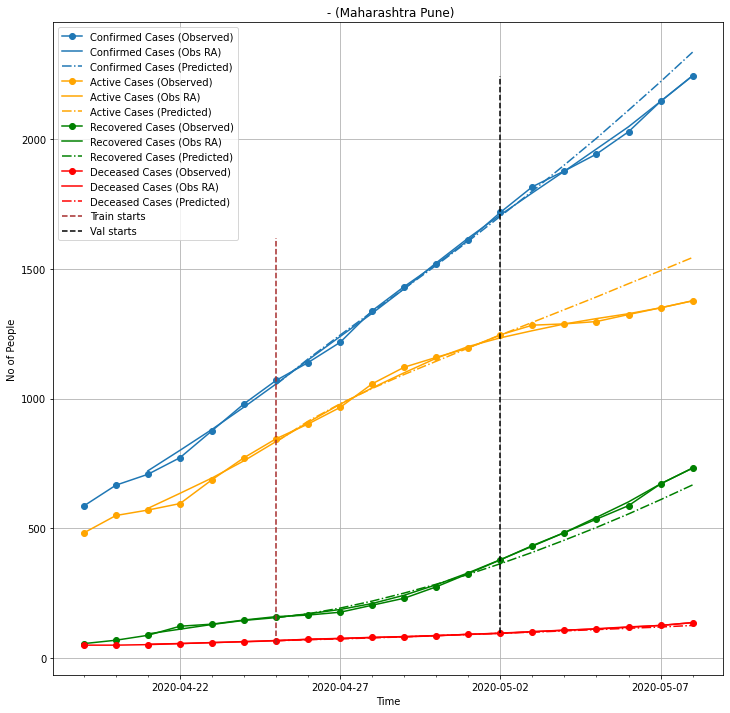

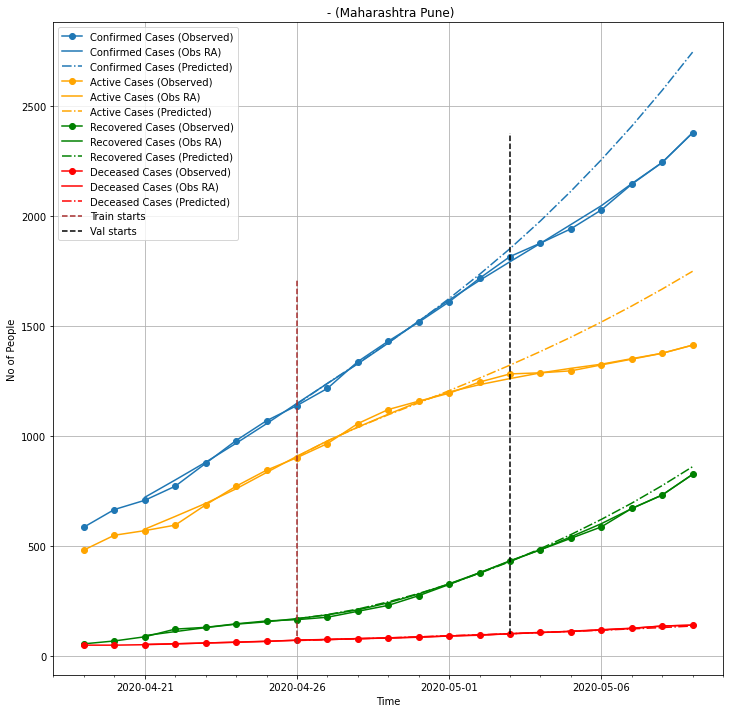

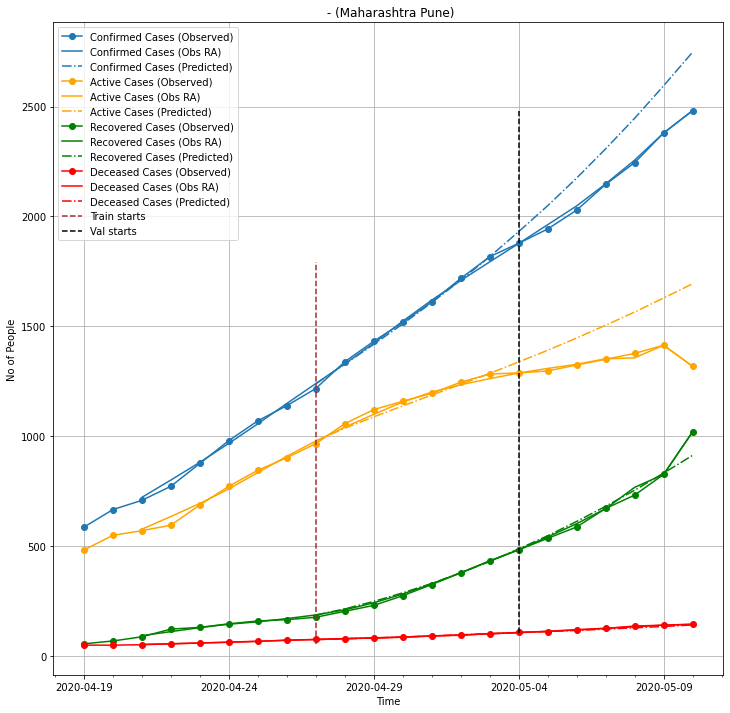

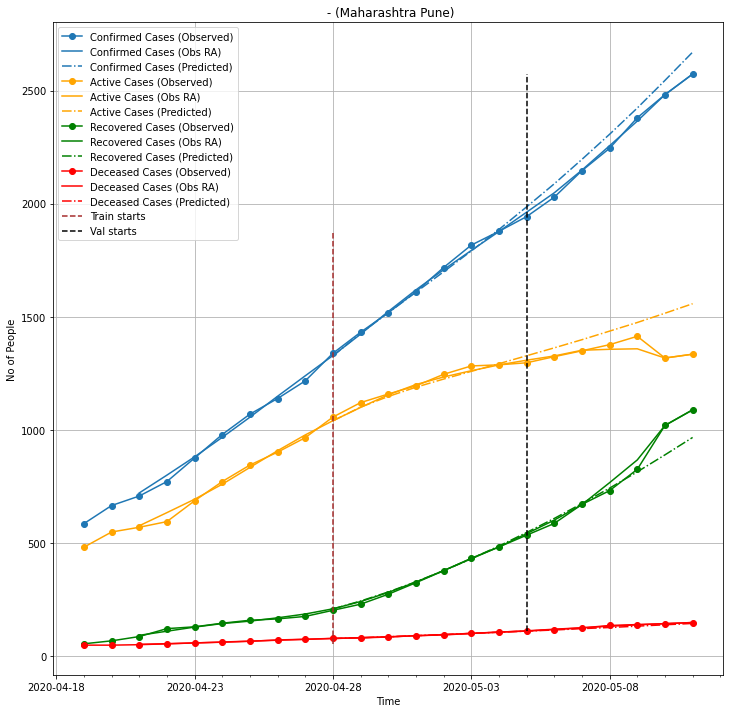

In [109]:
out = backtesting(df_district, df_district_raw_data, future_days=7, increment=1, train_period=train_period, val_period=val_period)

In [110]:
out['results'].keys()

dict_keys([Timestamp('2020-05-04 00:00:00'), Timestamp('2020-05-05 00:00:00'), Timestamp('2020-05-06 00:00:00'), Timestamp('2020-05-07 00:00:00'), Timestamp('2020-05-08 00:00:00'), Timestamp('2020-05-09 00:00:00'), Timestamp('2020-05-10 00:00:00'), Timestamp('2020-05-11 00:00:00')])

In [111]:
for run in out['results'].keys():
    print(out['results'][run]['results']['df_loss'])
    # print(out['results'][run]['results']['df_prediction'])

train      val
hospitalised     1.82284  6.04166
total_infected   1.60139  3.19069
deceased        0.929194  5.79367
recovered        7.86099  11.7633
                  train      val
hospitalised    1.71974  10.8578
total_infected  1.46339  5.17616
deceased         1.0673  6.71895
recovered       5.79691  20.0322
                   train      val
hospitalised    0.784293  10.9871
total_infected  0.746835  4.87716
deceased         1.35772  6.58717
recovered        3.76359  19.4383
                  train      val
hospitalised    1.15501  7.87183
total_infected  1.09932   1.5382
deceased        1.28699  1.59685
recovered       4.09663  25.6154
                   train      val
hospitalised     1.38276  5.78446
total_infected  0.907969  2.47498
deceased         1.49545  3.59187
recovered        4.80198  6.96869
                   train      val
hospitalised     1.24485  12.1875
total_infected  0.825732  8.89991
deceased         1.73989  1.81207
recovered         3.5162  3.36834
         

In [112]:
def create_plots(results, df_train, df_val, df_train_nora, df_val_nora, train_period, state, district, 
                 which_compartments=['hospitalised', 'total_infected'], description=''):
    # Create plots
    if isinstance(df_val, pd.DataFrame):
        df_true_plotting_rolling = pd.concat([df_train, df_val], ignore_index=True)
        df_true_plotting = pd.concat([df_train_nora, df_val_nora], ignore_index=True)
    else:
        df_true_plotting_rolling = df_train
        df_true_plotting = df_train_nora
    
    # import pdb; pdb.set_trace()
    if 'total_infected' in which_compartments:
        plt.plot(df_true_plotting['date'], df_true_plotting['total_infected'],
                '-o', color='C0', label='Confirmed Cases', markersize=3)
        plt.plot(df_true_plotting_rolling['date'], df_true_plotting_rolling['total_infected'],
                '-', color='C0', linewidth=.25)
    if 'hospitalised' in which_compartments:
        plt.plot(df_true_plotting['date'], df_true_plotting['hospitalised'],
                '-o', color='orange', label='Active Cases', markersize=3)
        plt.plot(df_true_plotting_rolling['date'], df_true_plotting_rolling['hospitalised'],
                '-', color='orange', linewidth=.25)
    if 'recovered' in which_compartments:
        plt.plot(df_true_plotting['date'], df_true_plotting['recovered'],
                '-o', color='green', label='Recovered Cases', markersize=3)
        plt.plot(df_true_plotting_rolling['date'], df_true_plotting_rolling['recovered'],
                '-', color='green', linewidth=.25)
    if 'deceased' in which_compartments:
        plt.plot(df_true_plotting['date'], df_true_plotting['deceased'],
                '-o', color='red', label='Deceased Cases', markersize=3)
        plt.plot(df_true_plotting_rolling['date'], df_true_plotting_rolling['deceased'],
                '-', color='red', linewidth=.25)

    for i, run in enumerate(results.keys()):
        color_idx = i/len(results.keys())
        df_pred_run = results[run]['results']['df_prediction']
        df_predicted_plotting_run = df_pred_run.loc[df_pred_run['date'].isin(
            df_true_plotting['date']), ['date', 'hospitalised', 'total_infected', 'deceased', 'recovered']]
        if 'total_infected' in which_compartments:
            cmap = mpl.cm.get_cmap('winter')
            color = cmap(color_idx)
            plt.plot(df_predicted_plotting_run['date'], df_predicted_plotting_run['total_infected'],
                    '-.', color=cmap(color_idx))
        if 'hospitalised' in which_compartments:
            cmap = mpl.cm.get_cmap('Wistia')
            plt.plot(df_predicted_plotting_run['date'], df_predicted_plotting_run['hospitalised'],
                    '-.', color=cmap(color_idx))
        if 'recovered' in which_compartments:
            cmap = mpl.cm.get_cmap('summer')
            plt.plot(df_predicted_plotting_run['date'], df_predicted_plotting_run['recovered'],
                    '-.', color=cmap(color_idx))
        if 'deceased' in which_compartments:
            cmap = mpl.cm.get_cmap('autumn')
            plt.plot(df_predicted_plotting_run['date'], df_predicted_plotting_run['deceased'],
                    '-.', color=cmap(color_idx))
    
    ax = plt.gca()
    ax.xaxis.set_major_locator(mdates.DayLocator(interval=7))
    ax.xaxis.set_minor_locator(mdates.DayLocator(interval=1))
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%d-%m'))
    plt.ylabel('No of People')
    plt.legend()
    plt.title('{} - ({} {})'.format(description, state, district))
    plt.grid()

In [113]:
df_district, df_district_raw_data, df_train, df_val, df_true_fitting, df_train_nora, df_val_nora = \
            data_setup(df_district, df_district_raw_data, pre_lockdown, train_on_val, val_period)

splitting data ..
splitting data ..


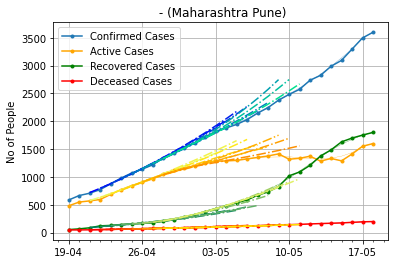

In [114]:
create_plots(out['results'], df_train, df_val, df_train_nora, df_val_nora, train_period, state, district, 
                 which_compartments=which_compartments)

In [115]:
for run in out['results'].keys():
    print(out['results'][run]['results']['df_loss'].loc['deceased','val'])

5.793672221491364
6.718946072447801
6.587171698884218
1.5968506453383318
3.591871443661875
1.812071934838745
2.5688317236655416
3.2698099120365347


In [116]:
def plot_backtesting_errors(state, district, results, compartment='total_infected',description=''):
    plt.title('{} - ({} {})'.format(description, state, district))
    # plot error
    dates = [run_day for run_day in results.keys()]
    errs = [results[run_day]['results']['df_loss'].loc[compartment,'val'] for run_day in results.keys()]
    plt.plot(dates, errs, ls='-', c='crimson',
        label='mape')

    ax = plt.gca()
    ax.xaxis.set_major_locator(mdates.DayLocator(interval=3))
    ax.xaxis.set_minor_locator(mdates.DayLocator(interval=1))
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%d-%m'))
    plt.ylabel('MAPE')
    plt.legend()
    plt.grid()
    return

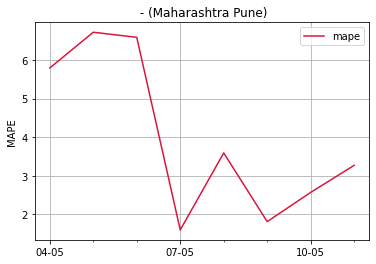

In [117]:
plot_backtesting_errors(state, district, out['results'], compartment='deceased')

In [119]:
from main.seir.backtesting import SEIRBacktest


In [120]:

state, district = 'Maharashtra', 'Pune'
fit = 'm1' # 'm1' or 'm2'
data_from_tracker=False


In [121]:
if district == 'Mumbai':
    data_format = 'old'
    filepath = '../../data/data/official-mumbai.csv'
elif district == 'Pune':
    data_format = 'new'
    filepath = '../../data/data/official-pune-21-05-20.csv'

In [122]:
df_district, df_district_raw_data = get_all_district_data(dataframes, state, district, 
                data_from_tracker, data_format, filepath)

backtester = SEIRBacktest(state, district, df_district, df_district_raw_data, data_from_tracker)


2020-04-19 00:00:00 2020-05-18 00:00:00
backtesting for 2020-05-04 00:00:00splitting data ..
splitting data ..
100%|██████████| 1000/1000 [08:56<00:00,  1.87trial/s, best loss: 6.900443900628211]
best parameters
 {'E_hosp_ratio': 1.0371445402114345, 'I_hosp_ratio': 0.5501142628832003, 'P_fatal': 0.1476944278170766, 'P_severe': 0.6852394286778005, 'T_inc': 4.790547019810249, 'T_inf': 3.873029149603186, 'T_recov_severe': 44.009827810799244, 'lockdown_R0': 1.3746295698006579}
backtesting for 2020-05-07 00:00:00splitting data ..
splitting data ..
100%|██████████| 1000/1000 [07:50<00:00,  2.12trial/s, best loss: 4.315714649653888]
best parameters
 {'E_hosp_ratio': 0.6199864808416851, 'I_hosp_ratio': 0.5531013779421945, 'P_fatal': 0.10214379988116855, 'P_severe': 0.6266373831852616, 'T_inc': 4.997812166217382, 'T_inf': 3.316478206117629, 'T_recov_severe': 56.15947046325303, 'lockdown_R0': 1.1605876106173196}
backtesting for 2020-05-10 00:00:00splitting data ..
splitting data ..
100%|████████

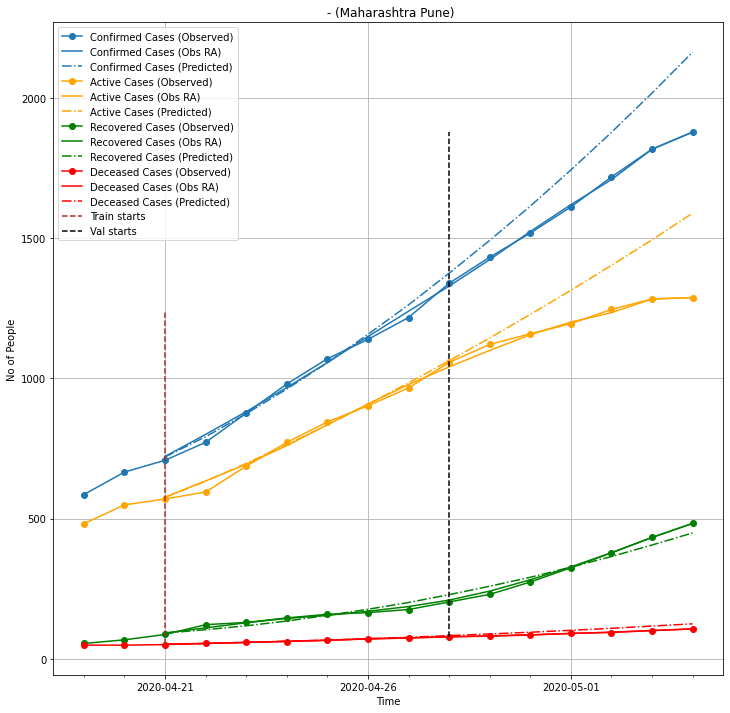

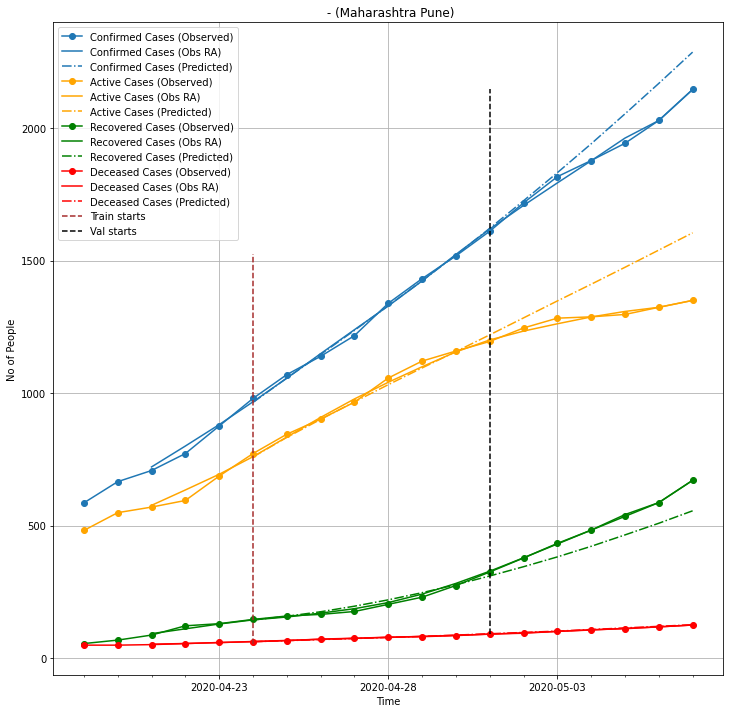

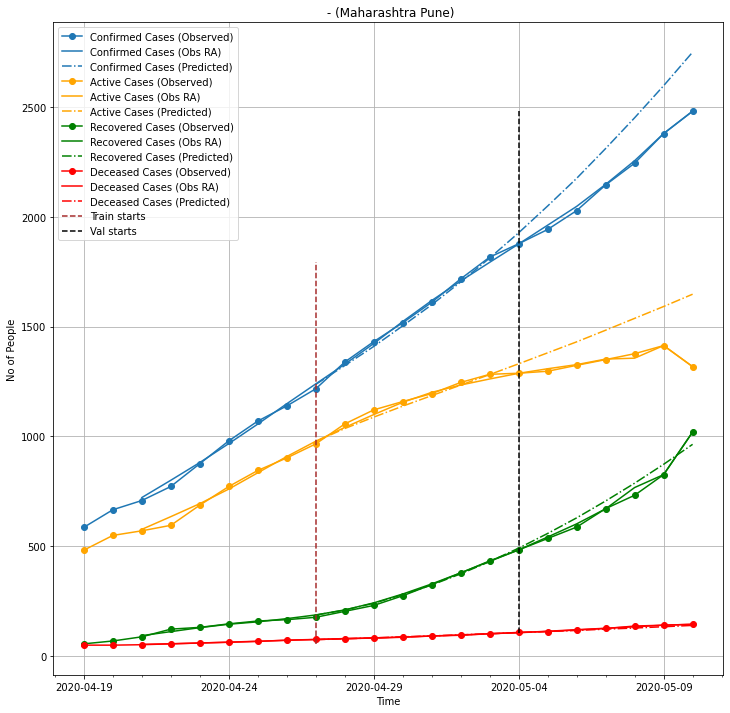

In [124]:
results = backtester.test(fit, increment=3)


In [125]:
backtester.plot_results(which_compartments=['total_infected', 'deceased', 'hospitalised', 'recovered'])


AttributeError: 'SEIRBacktest' object has no attribute 'backtest_results_dict'

In [ ]:
backtester.plot_errors(compartment='deceased')
